<a href="https://colab.research.google.com/github/parishwadomkar/Coding/blob/master/Satelite_image_segmentation_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connecting to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Necessary imports

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import os
import PIL
import random

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.metrics import Metric

import keras.losses 
from keras.metrics import binary_crossentropy
from keras import backend as K


%matplotlib inline
!pip install -U tensorflow-addons --quiet
!pip install livelossplot --quiet
!pip install tqdm --quiet
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
from tensorflow_addons.layers import GroupNormalization
from sklearn.preprocessing import MinMaxScaler

# Setting up directories

In [ ]:
train_dir = "/content/drive/MyDrive/satelite image segmentation UNET/satelite image/train_images/"
train_mask = "/content/drive/MyDrive/satelite image segmentation UNET/satelite image/train_masks/"
test_dir = "/content/drive/MyDrive/satelite image segmentation UNET/satelite image/test_images/"
pred_dir = "/content/drive/MyDrive/satelite image segmentation UNET/satelite image/test_predictions/"

# Training and model building Variables

In [ ]:
BATCH_SIZE = 87
INPUT_SIZE = 512
N_CHANNEL = 3
N_CLASSES = 27

In [ ]:
img_names = [s[:-4] for s in os.listdir(train_dir)]
img_names_batches = [img_names[i:i + BATCH_SIZE] for i in range(0, len(img_names), BATCH_SIZE)]
print("Train images were split into batches of size {}.".format(BATCH_SIZE))
print("Number of batches = ",len(img_names_batches))

Train images were split into batches of size 87.
Number of batches =  3


# Utility functions

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)= sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.Ref: https://en.wikipedia.org/wiki/Jaccard_index
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32) #tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def get_predictions(image_loc, test_img_names):
    y_test = {}
    for i in tqdm(range(len(test_img_names))):
        x_test = np.array(PIL.Image.open(image_loc + test_img_names[i] + ".jpg").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255 #
        x_test = x_test.reshape((1,INPUT_SIZE,INPUT_SIZE,3))
        y_test[test_img_names[i]] = model.predict(x_test, verbose=0)
        del x_test
    return y_test
    
def create_mask(image_dict):
    y_test_mask = {}
    print("Creating masks for {} predictions".format(len(image_dict)))
    for name, img in image_dict.items():
        pred_mask = tf.argmax(img, axis=3)
        pred_mask= np.uint8(pred_mask[0].numpy())
        y_test_mask[name] = pred_mask
    return y_test_mask

def save_mask(mask_dict):
    for name, mask in tqdm(mask_dict.items()):
        im = PIL.Image.fromarray(mask)
        im.save(pred_dir + str(name) + '.png')

# Defining early stopping and checkpoint

In [ ]:
early_stopping = EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/satelite image segmentation UNET/keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)

# setting up checkpoint
filepath="/content/drive/MyDrive/satelite image segmentation UNET/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Initiating loss functions

In [ ]:
keras.losses.custom_objects = bce_dice_loss
keras.losses.custom_objects = jaccard_distance_loss
keras.metrics.custom_objects = mean_iou
keras.api._v2.keras.metrics.custom_objects = mean_iou

# Building U-NET

In [ ]:
model = None
inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
drop1 = Dropout(0.2)(pool1) # Dropout(0.2)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop2 = Dropout(0.2)(pool2) #Dropout(0.2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
drop3 = Dropout(0.2)(pool3) 

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
drop4 = Dropout(0.2)(pool4) # Dropout(0.2)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

conv10 = Conv2D(N_CLASSES, (1, 1), activation="softmax")(conv9) #

model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss= bce_dice_loss, metrics=['accuracy']) 
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 512, 512, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_58 (Conv2D)             (None, 512, 512, 32  9248        ['conv2d_57[0][0]']              
                                )                                                           

In [ ]:
EPOCHS = 500 # max
TRAINING_SAVE_LOC = "/content/drive/MyDrive/satelite image segmentation UNET/training/"

train_hist = {}

for b,img_names in enumerate(img_names_batches):
    x = []
    y = []
    z = []
    for i in img_names:
        x.append(np.array(PIL.Image.open(train_dir + i + ".jpg").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255.)
        y.append(to_categorical(np.array(PIL.Image.open(train_mask + i + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST)), N_CLASSES))
        z.append(np.array(np.array(PIL.Image.open(train_mask + i + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))))

    x = np.array(x) # train images
    y = np.array(y) # train mask images
    z = np.array(z) # variable used only for image visualization

    x = np.append(x, [np.fliplr(i) for i in x], axis=0) #data augmentation (flipping)
    y = np.append(y, [np.fliplr(i) for i in y], axis=0) #data augmentation (flipping)

    val_samples = 27
    x_train = x[:-val_samples]
    y_train = y[:-val_samples]
    x_val = x[-val_samples:]
    y_val = y[-val_samples:]

    
    # Training the model
    model_history = model.fit(x_train, y_train, batch_size=8, epochs=EPOCHS, validation_data=(x_val, y_val), shuffle=True, callbacks=[early_stopping]) 
    train_hist[b] = model_history

    # Saving the model
    print("Saving the model")
    BATCH_LOC = "batch_" + str(b) + "/"
    CURRENT_SAVE_LOC = TRAINING_SAVE_LOC + BATCH_LOC
    model.save(CURRENT_SAVE_LOC)
    print("Saved the model at", CURRENT_SAVE_LOC)
    

Epoch 1/500
19/19 [==============================] - 6s 231ms/step - loss: 1.5171 - accuracy: 0.1197 - val_loss: 1.3408 - val_accuracy: 0.1832
Epoch 2/500
19/19 [==============================] - 3s 179ms/step - loss: 1.1987 - accuracy: 0.1671 - val_loss: 1.0437 - val_accuracy: 0.2771
Epoch 3/500
19/19 [==============================] - 3s 180ms/step - loss: 0.9355 - accuracy: 0.3360 - val_loss: 0.9256 - val_accuracy: 0.3382
Epoch 4/500
19/19 [==============================] - 3s 179ms/step - loss: 0.8426 - accuracy: 0.3420 - val_loss: 0.8572 - val_accuracy: 0.3428
Epoch 5/500
19/19 [==============================] - 3s 179ms/step - loss: 0.7972 - accuracy: 0.3663 - val_loss: 0.8030 - val_accuracy: 0.4199
Epoch 6/500
19/19 [==============================] - 3s 179ms/step - loss: 0.7522 - accuracy: 0.4110 - val_loss: 0.7195 - val_accuracy: 0.4341
Epoch 7/500
19/19 [==============================] - 3s 178ms/step - loss: 0.7110 - accuracy: 0.4443 - val_loss: 0.6493 - val_accuracy: 0.5029

Saved the model at /content/drive/MyDrive/satelite image segmentation UNET/training/batch_0/
Epoch 1/500
19/19 [==============================] - 4s 203ms/step - loss: 0.4666 - accuracy: 0.6446 - val_loss: 0.5053 - val_accuracy: 0.6102
Epoch 2/500
19/19 [==============================] - 3s 178ms/step - loss: 0.4039 - accuracy: 0.6847 - val_loss: 0.3984 - val_accuracy: 0.6958
Epoch 3/500
19/19 [==============================] - 3s 178ms/step - loss: 0.3505 - accuracy: 0.7269 - val_loss: 0.3776 - val_accuracy: 0.7053
Epoch 4/500
19/19 [==============================] - 3s 177ms/step - loss: 0.3224 - accuracy: 0.7478 - val_loss: 0.3364 - val_accuracy: 0.7370
Epoch 5/500
19/19 [==============================] - 3s 180ms/step - loss: 0.3021 - accuracy: 0.7636 - val_loss: 0.3273 - val_accuracy: 0.7440
Epoch 6/500
19/19 [==============================] - 3s 177ms/step - loss: 0.2977 - accuracy: 0.7670 - val_loss: 0.3551 - val_accuracy: 0.7185
Epoch 7/500
19/19 [==============================

Saved the model at /content/drive/MyDrive/satelite image segmentation UNET/training/batch_1/
Epoch 1/500
19/19 [==============================] - 4s 201ms/step - loss: 0.4339 - accuracy: 0.6611 - val_loss: 0.3734 - val_accuracy: 0.7100
Epoch 2/500
19/19 [==============================] - 3s 177ms/step - loss: 0.3478 - accuracy: 0.7332 - val_loss: 0.3355 - val_accuracy: 0.7372
Epoch 3/500
19/19 [==============================] - 3s 176ms/step - loss: 0.3293 - accuracy: 0.7437 - val_loss: 0.3561 - val_accuracy: 0.7231
Epoch 4/500
19/19 [==============================] - 3s 176ms/step - loss: 0.3273 - accuracy: 0.7475 - val_loss: 0.3408 - val_accuracy: 0.7352
Epoch 5/500
19/19 [==============================] - 3s 181ms/step - loss: 0.3011 - accuracy: 0.7665 - val_loss: 0.3153 - val_accuracy: 0.7526
Epoch 6/500
19/19 [==============================] - 3s 177ms/step - loss: 0.2848 - accuracy: 0.7787 - val_loss: 0.3239 - val_accuracy: 0.7505
Epoch 7/500
19/19 [==============================

Saved the model at /content/drive/MyDrive/satelite image segmentation UNET/training/batch_2/


In [ ]:
model.save("/content/drive/MyDrive/satelite image segmentation UNET/final_model.h5")

# Training loss vs validation loss

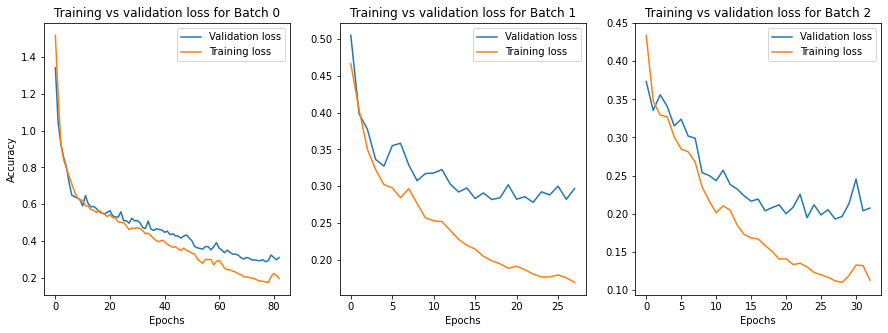

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].plot(train_hist[0].epoch, train_hist[0].history["val_loss"], label = "Validation loss")
axs[0].plot(train_hist[0].epoch, train_hist[0].history["loss"], label = "Training loss")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel("Accuracy")
axs[0].set_title('Training vs validation loss for Batch 0')
axs[0].legend(loc='upper right')

axs[1].plot(train_hist[1].epoch, train_hist[1].history["val_loss"], label = "Validation loss")
axs[1].plot(train_hist[1].epoch, train_hist[1].history["loss"], label = "Training loss")
axs[1].set_xlabel('Epochs')
axs[1].set_title('Training vs validation loss for Batch 1')
axs[1].legend(loc='upper right')

axs[2].plot(train_hist[2].epoch, train_hist[2].history["val_loss"], label = "Validation loss")
axs[2].plot(train_hist[2].epoch, train_hist[2].history["loss"], label = "Training loss")
axs[2].set_xlabel('Epochs')
axs[2].set_title('Training vs validation loss for Batch 2')
axs[2].legend(loc='upper right')

# Training accuracy vs validation accuracy

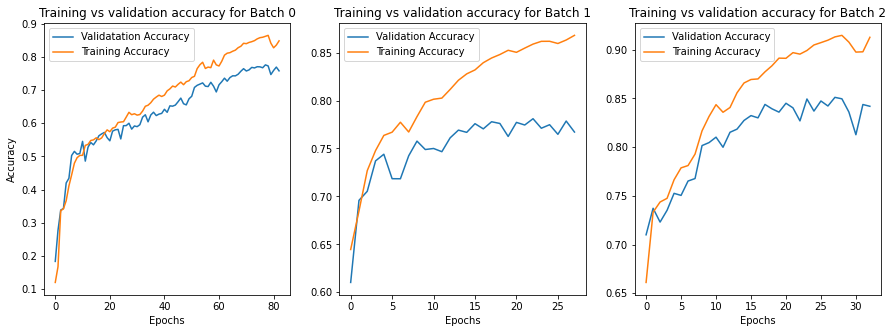

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].plot(train_hist[0].epoch, train_hist[0].history["val_accuracy"], label = "Validatation Accuracy")
axs[0].plot(train_hist[0].epoch, train_hist[0].history["accuracy"], label = "Training Accuracy")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel("Accuracy")
axs[0].set_title('Training vs validation accuracy for Batch 0')
axs[0].legend(loc='upper left')

axs[1].plot(train_hist[1].epoch, train_hist[1].history["val_accuracy"], label = "Validation Accuracy")
axs[1].plot(train_hist[1].epoch, train_hist[1].history["accuracy"], label = "Training Accuracy")
axs[1].set_xlabel('Epochs')
axs[1].set_title('Training vs validation accuracy for Batch 1')
axs[1].legend(loc='upper left')

axs[2].plot(train_hist[2].epoch, train_hist[2].history["val_accuracy"], label = "Validation Accuracy")
axs[2].plot(train_hist[2].epoch, train_hist[2].history["accuracy"], label = "Training Accuracy")
axs[2].set_xlabel('Epochs')
axs[2].set_title('Training vs validation accuracy for Batch 2')
axs[2].legend(loc='upper left')

In [ ]:
loss, acc = model.evaluate(x_val, y_val, verbose=2)

1/1 - 2s - loss: 0.1932 - accuracy: 0.8511 - 2s/epoch - 2s/step


# Load model

In [ ]:
USE_CURRENT_MODEL = False
SAVED_MODEL_LOC = "/content/drive/MyDrive/satelite image segmentation UNET/final_model.h5"
if not USE_CURRENT_MODEL:
    model = tf.keras.models.load_model(SAVED_MODEL_LOC, compile=False)
    print("Model loaded from ", SAVED_MODEL_LOC)

Model loaded from  /content/drive/MyDrive/satelite image segmentation UNET/final_model.h5


# Prediction on training image

Prediction on: /content/drive/MyDrive/satelite image segmentation UNET/satelite image/train_images/7477.jpg


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

Creating masks for 1 predictions


Text(0.5, 1.0, 'Predicted Mask')

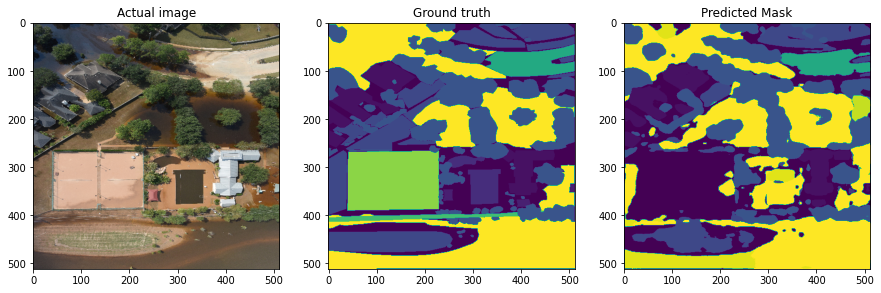

In [ ]:
image_name = random.choice(os.listdir(train_dir))[:-4]
print("Prediction on: {}.jpg".format(train_dir+image_name))

test_img = np.array(PIL.Image.open(train_dir + image_name +'.jpg').resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255
ground_truth = np.array(PIL.Image.open(train_mask + image_name + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))

img_name = [image_name]
pred = get_predictions(train_dir,img_name)
mask = create_mask(pred)
pred_img = mask[image_name]

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(test_img)
axs[0].set_title('Actual image')
axs[1].imshow(ground_truth)
axs[1].set_title('Ground truth')
axs[2].imshow(pred_img)
axs[2].set_title('Predicted Mask')


# Prediction on test image

Prediction on: /content/drive/MyDrive/satelite image segmentation UNET/satelite image/test_images/10808.jpg


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

Creating masks for 1 predictions


Text(0.5, 1.0, 'Predicted Mask')

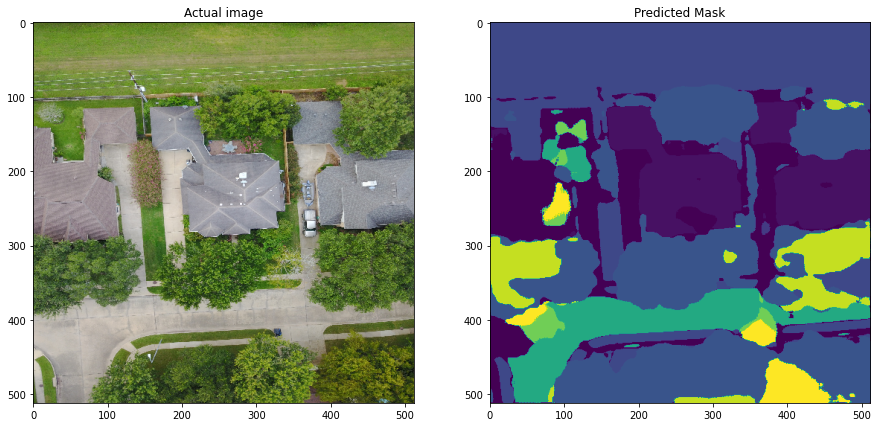

In [ ]:
image_name = random.choice(os.listdir(test_dir))[:-4]
print("Prediction on: {}.jpg".format(test_dir+image_name))

test_img = np.array(PIL.Image.open(test_dir + image_name +'.jpg').resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255

img_name = [image_name]
pred = get_predictions(test_dir, img_name)
mask = create_mask(pred)
mask_img = mask[image_name]

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(test_img)
axs[0].set_title('Actual image')
axs[1].imshow(mask_img)
axs[1].set_title('Predicted Mask')

# Prediction on the all the test images

In [ ]:
test_img_names = sorted([s[:-4] for s in os.listdir(test_dir)])
print("Total number of test images = ", len(test_img_names))

preds = get_predictions(test_dir ,test_img_names)
masks = create_mask(preds)
print("\nSaving preiction mask in {}".format(pred_dir))
save_mask(masks)

Total number of test images =  112


100%|██████████| 112/112 [00:30<00:00,  3.66it/s]


Creating masks for 112 predictions

Saving preiction mask in /content/drive/MyDrive/satelite image segmentation UNET/satelite image/test_predictions/


100%|██████████| 112/112 [00:01<00:00, 97.91it/s]


## Visualize prediction result from a random image

Prediction on: /content/drive/MyDrive/satelite image segmentation UNET/satelite image/test_images/6933.jpg


Text(0.5, 1.0, 'Predcitoin')

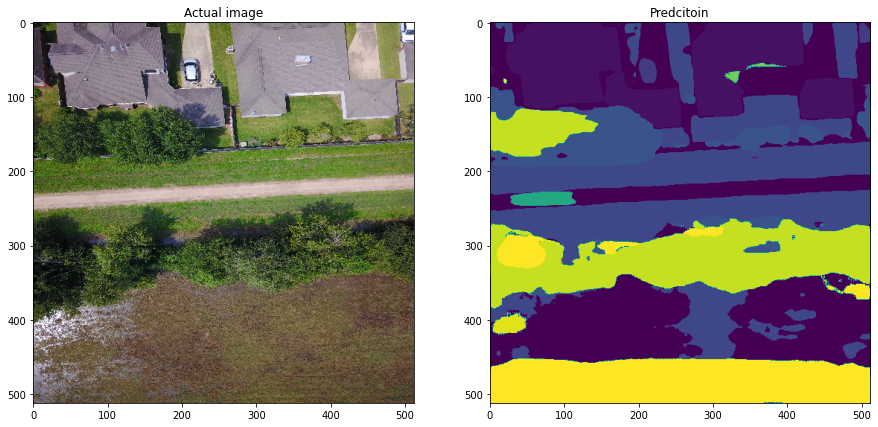

In [ ]:
image_name = random.choice(os.listdir(test_dir))[:-4]
print("Prediction on: {}.jpg".format(test_dir+image_name))

test_img = np.array(PIL.Image.open(test_dir + image_name +'.jpg').resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255
pred_img = np.array(PIL.Image.open(pred_dir + image_name + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(test_img)
axs[0].set_title('Actual image')
axs[1].imshow(pred_img)
axs[1].set_title('Predcitoin')

# Generating submission_file.csv

In [ ]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles(test_pred_dir):
    """Used for Kaggle submission: predicts and encode all test images"""
    N = len([i for i in list(os.listdir(test_pred_dir)) if i[-3:] == "png"])
    # .csv file path
    with open('/content/drive/MyDrive/satelite image segmentation UNET/submission_file.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in tqdm(enumerate(os.listdir(test_pred_dir))):
            if i[-3:] == "png":
                # print('Saving {}/{}'.format(index, N))
                mask = PIL.Image.open(test_pred_dir + i)
                mask = mask.resize((1024, 1024), resample= PIL.Image.NEAREST)
                mask = np.array(mask)
                for x in range(1, 25):
                    enc = rle_encode(mask == x)
                    f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles(pred_dir) 

112it [00:08, 13.84it/s]


# This part is for submitting to kaggle

In [ ]:
!kaggle competitions submit -c fdl21-fdl-dsba -f submissions/submission_file.csv -m "batch 87 change t20 m0"